In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("YouTube_Combined_Cleaned (1).csv")
df['published'] = pd.to_datetime(df['published'], errors='coerce', utc=True)
now = pd.Timestamp.utcnow()
df['channel_age_years'] = (now - df['published']).dt.days / 365.25

df['views_per_video'] = np.where(df['videos'] > 0, df['views']/df['videos'], np.nan)
df['subs_per_video']  = np.where(df['videos'] > 0, df['subs']/df['videos'], np.nan)
df['views_per_sub']   = np.where(df['subs'] > 0, df['views']/df['subs'], np.nan)

df = df.dropna(subset=['views','subs','videos','channel_age_years'])


In [8]:
y = np.log1p(df['subs'])   # log-transform to reduce skew
X = df[['views','videos','channel_age_years']]
X = np.log1p(X)   # log-transform features

X.head(), y.head()

(       views    videos  channel_age_years
 0  16.625452  4.700480           2.191122
 1  21.849565  7.937017           2.043999
 2  21.884367  7.234898           2.026472
 3  21.129880  6.152733           3.024241
 4  13.110086  5.463832           2.832085,
 0    11.589896
 1    16.364956
 2    15.870916
 3    14.279245
 4     7.867489
 Name: subs, dtype: float64)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (23102, 3) Test size: (5776, 3)


In [10]:
# baseline linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

print("Linear Regression R^2:", r2_score(y_test, y_pred))
print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Coefficients
coef_table = pd.DataFrame({
    "feature": X.columns,
    "coefficient": linreg.coef_
}).sort_values("coefficient", ascending=False)

coef_table

Linear Regression R^2: 0.8967314861311633
Linear Regression RMSE: 1.247787664212763


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,feature,coefficient
0,views,0.818104
1,videos,0.000843
2,channel_age_years,-0.392100


In [11]:
# random forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest R^2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))

# Feature importance
imp_table = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

imp_table

Random Forest R^2: 0.9353042803693123
Random Forest RMSE: 0.9876305111644864


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,feature,importance
0,views,0.947553
2,channel_age_years,0.032617
1,videos,0.019830


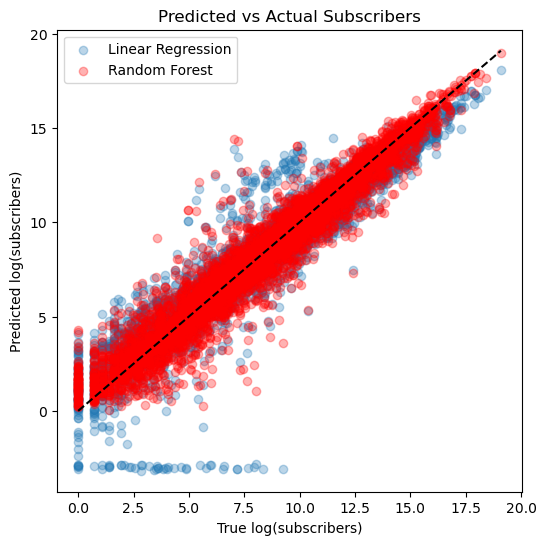

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Linear Regression")
plt.scatter(y_test, y_pred_rf, alpha=0.3, label="Random Forest", color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True log(subscribers)")
plt.ylabel("Predicted log(subscribers)")
plt.legend()
plt.title("Predicted vs Actual Subscribers")
plt.show()


In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "R2": r2_score(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False)
    }

In [14]:
results = {}

# Linear Regression
linreg = LinearRegression()
results['Linear Regression'] = evaluate_model(linreg, X_train, y_train, X_test, y_test)

# Ridge Regression
ridge = Ridge(alpha=1.0)
results['Ridge'] = evaluate_model(ridge, X_train, y_train, X_test, y_test)

# Lasso Regression
lasso = Lasso(alpha=0.001, max_iter=10000)
results['Lasso'] = evaluate_model(lasso, X_train, y_train, X_test, y_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
results['Random Forest'] = evaluate_model(rf, X_train, y_train, X_test, y_test)

pd.DataFrame(results).T

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

,R2,RMSE
Linear Regression,0.896731,1.247788
Ridge,0.896731,1.247788
Lasso,0.896729,1.247804
Random Forest,0.935304,0.987631


In [15]:
from sklearn.model_selection import cross_val_score

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    cv_results[name] = {"CV R2 Mean": scores.mean(), "CV R2 Std": scores.std()}

pd.DataFrame(cv_results).T

,CV R2 Mean,CV R2 Std
Linear Regression,0.890485,0.016234
Ridge,0.890485,0.016235
Lasso,0.890488,0.016250
Random Forest,0.929303,0.005671


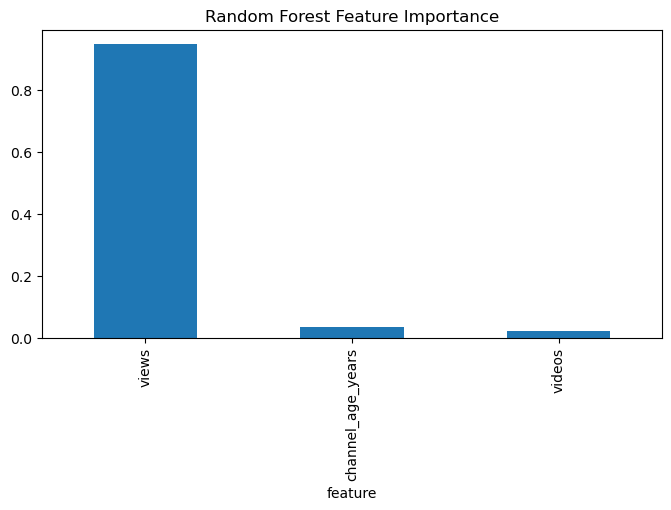

,feature,importance
0,views,0.947222
2,channel_age_years,0.032614
1,videos,0.020163


In [25]:
rf.fit(X, y)
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importances.plot(kind="bar", x="feature", y="importance", legend=False, figsize=(8,4))
plt.title("Random Forest Feature Importance")
plt.show()

importances


NameError: name 'rf' is not defined